In [1]:
'''
Module imports
'''
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import math

import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import kstest
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import nbinom
from scipy.stats import chi2_contingency
from scipy.stats import lognorm
from scipy.stats import beta

from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.discrete.discrete_model import Poisson
from statsmodels.stats.diagnostic import anderson_statistic

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor

%matplotlib inline
plt.style.use('ggplot')


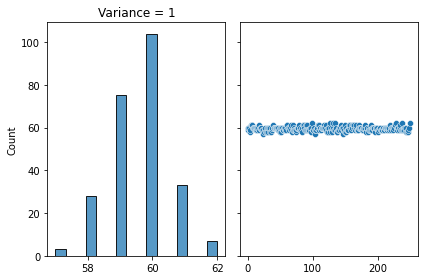

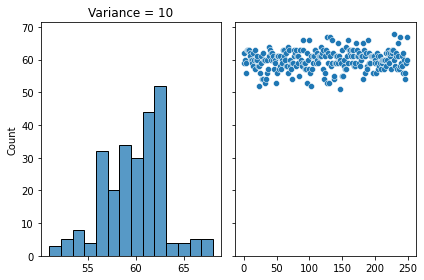

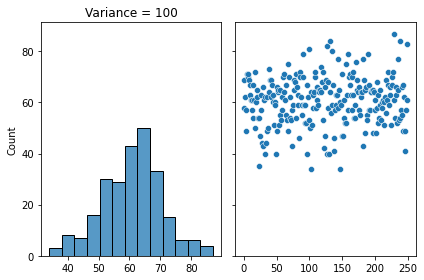

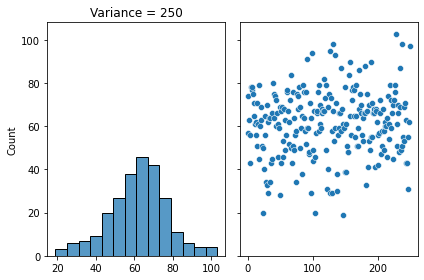

In [55]:
'''
These values are assumed to be across a 5MB segment.
(Maybe use truncnorm to simulate values above 0?)
scale = std haha
For a 5mb segment consisting of 20000 bins, mean count is roughly 60
Number of values depends on binsize. If 20000 then size is 250
From articles and few samples, var = 4mean
'''

for variance in [1,10,100, 250]:
    norm_values = np.array([int(rvs) for rvs in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    fig, ax = plt.subplots(1, 2, tight_layout=True, sharey=True)
    hist = sns.histplot(norm_values, ax=ax[0])
    scat = sns.scatterplot(x=np.arange(len(norm_values)),y=norm_values, ax=ax[1])
    ax[0].set_title(f'Variance = {variance}, mean = 60')
    plt.show()


(0.0, 0.14574546368934546)

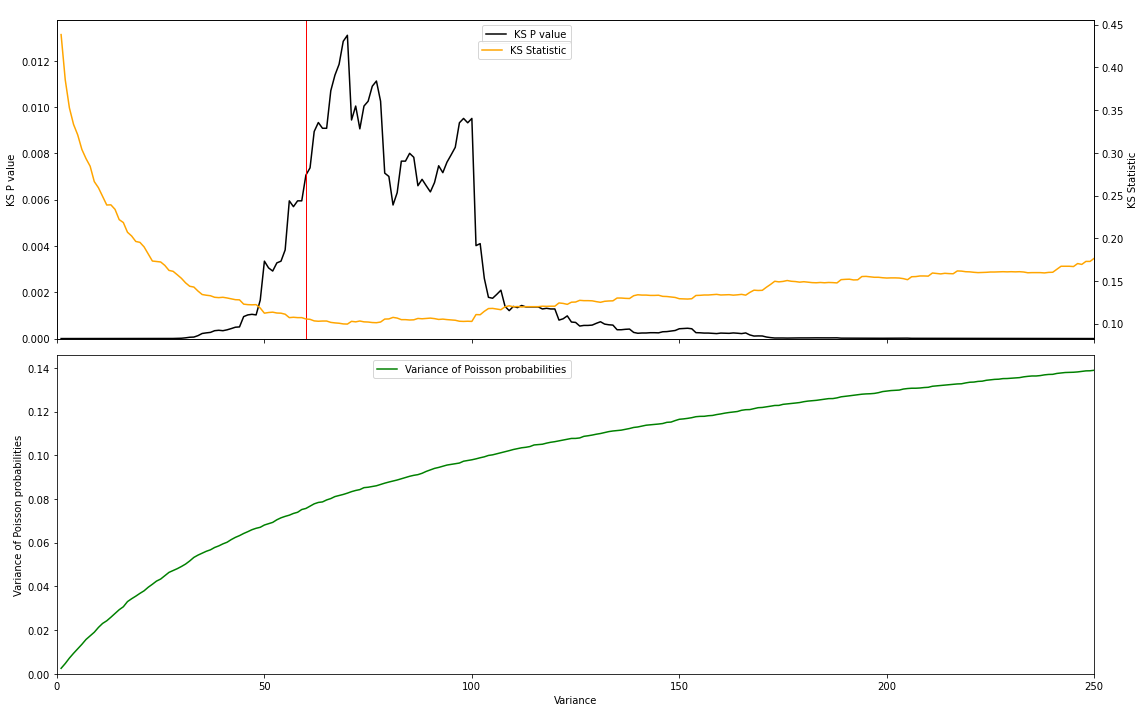

In [56]:
'''
The Kolmogorov-Smirnov Test With values from rvs.norm
sort parameter - lines connect points in the order they appear
'''
p_values = []

for variance in np.arange(1, 251):
    values = np.array([int(rvs) for rvs in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided')[1]
    ks_statistic = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided')[0]
    variance_poisson_p_value = pd.Series([poisson.cdf(k=e, mu=lmbda) for e in values]).var()
    p_values.append({'Variance':variance, 
                     'KS Pvalue': ks_p_value,
                     'KS Statistic': ks_statistic,
                     'Variance Poisson Pvalue': variance_poisson_p_value})


df = pd.DataFrame(p_values)

fig, ax = plt.subplots(2,1, figsize=(16,10), tight_layout=True, sharex=True)

l1 = sns.lineplot(data=df, x='Variance', y='KS Pvalue', sort=False, color='black', label='KS P value', palette='Set1', ax=ax[0])
l1.set_ylabel('KS P value')
l1.legend(bbox_to_anchor=(0.5, 1))
l1.axvline(x=60, ymin=0, ymax=1, color='red', linewidth=1)

l2 = sns.lineplot(data=df, x='Variance', y='KS Statistic', color='orange', sort=False, label='KS Statistic', ax=ax[0].twinx())
l2.set_ylabel('KS Statistic')
l2.legend(bbox_to_anchor=(0.5, 0.95))
ax[0].set_xlim(left=0, right=250)
ax[0].set_ylim(bottom=0)

___line = sns.lineplot(data=df, x='Variance', y='Variance Poisson Pvalue', label='Variance of Poisson probabilities',sort=False, color='green', ax=ax[1])
___line.set_ylabel('Variance of Poisson probabilities')
___line.legend(bbox_to_anchor=(0.5, 1))
ax[1].set_xlim(left=0, right=250)
ax[1].set_ylim(bottom=0)

Text(0, -40, 'The Null hypothesis for the KS test is that the distribution being tested is Poisson distributed.\n\nExact, Approx and Asymp are modes for calculating the KS P value:\n\nExact - Uses the exact distribution of the KS statistic.\nApprox - Approximates a two sided probability with twice the one sided.\nAsymp - Uses an asymptotic distribution for the KS statistic.\n\nFurthermore "Greater" or "Less" indicates whether the the cdf of the distribution being tested is less than or greater than the poisson cdf.\n\n A possible important limitation of the KS Test is that it tends to be more sensitive near the middle of the distribution than the edges')

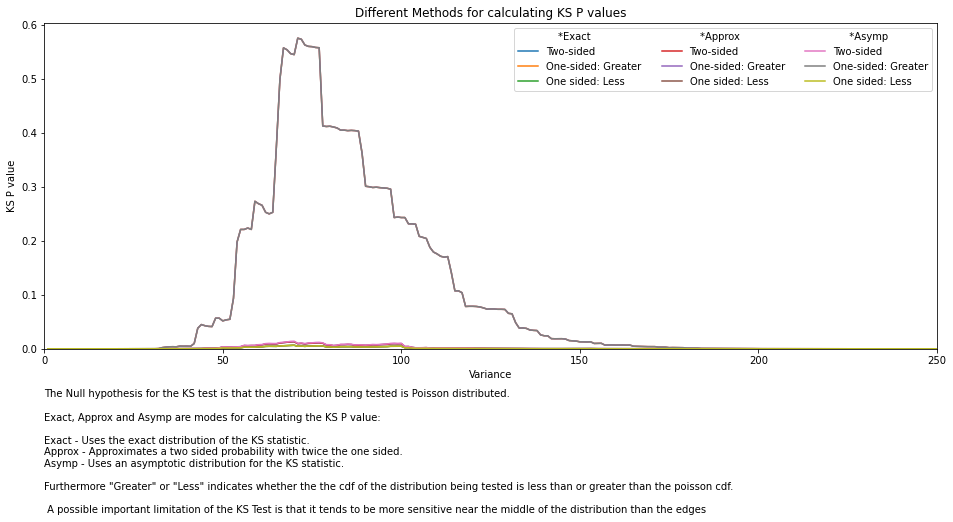

In [57]:
'''
Further Simulated Testing with KS Test
'''
p_values = []

for variance in np.arange(1, 251):
    values = np.array([int(rvs) for rvs in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    exact_double_sided_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided', mode='exact')[1]
    exact_greater_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='greater', mode='exact')[1]
    exact_less_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='less', mode='exact')[1]
    approx_double_sided_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided', mode='approx')[1]
    approx_greater_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='greater', mode='approx')[1]
    approx_less_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='less', mode='approx')[1]
    asymp_double_sided_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided', mode='asymp')[1]
    asymp_greater_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='greater', mode='asymp')[1]
    asymp_less_ks_p_value = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='less', mode='asymp')[1]
    p_values.append({'Variance': variance,
                     'Exact Double':exact_double_sided_ks_p_value, 
                     'Exact Greater': exact_greater_ks_p_value, 
                     'Exact Less': exact_less_ks_p_value, 
                     'Approx Double':approx_double_sided_ks_p_value, 
                     'Approx Greater': approx_greater_ks_p_value, 
                     'Approx Less': approx_less_ks_p_value, 
                     'Asymp Double':asymp_double_sided_ks_p_value, 
                     'Asymp Greater': asymp_greater_ks_p_value, 
                     'Asymp Less': asymp_less_ks_p_value})

df = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(16,6))

scatter1 = sns.lineplot(data=df, x='Variance', y='Exact Double', label='Two-sided', sort=False, ax=ax)
scatter2 = sns.lineplot(data=df, x='Variance', y='Exact Greater', label='One-sided: Greater', sort=False, ax=ax)
scatter3 = sns.lineplot(data=df, x='Variance', y='Exact Less', label='One sided: Less', sort=False, ax=ax)

scatter4 = sns.lineplot(data=df, x='Variance', y='Approx Double', label='Two-sided', sort=False, ax=ax)
scatter5 = sns.lineplot(data=df, x='Variance', y='Approx Greater', label='One-sided: Greater', sort=False, ax=ax)
scatter6 = sns.lineplot(data=df, x='Variance', y='Approx Less', label='One sided: Less', sort=False, ax=ax)

scatter7 = sns.lineplot(data=df, x='Variance', y='Asymp Double', label='Two-sided', sort=False, ax=ax)
scatter8 = sns.lineplot(data=df, x='Variance', y='Asymp Greater', label='One-sided: Greater', sort=False, ax=ax)
scatter9 = sns.lineplot(data=df, x='Variance', y='Asymp Less', label='One sided: Less', sort=False, ax=ax)

ax.set_title('Different Methods for calculating KS P values')
ax.set_ylabel('KS P value')
ax.set_xlim(left=0, right=250)
ax.set_ylim(bottom=0)
ax.legend(ncol=3, title='*Exact                                   *Approx                                   *Asymp')
ax.annotate('The Null hypothesis for the KS test is that the distribution being tested is Poisson distributed.\n\nExact, Approx and Asymp are modes for calculating the KS P value:\n\nExact - Uses the exact distribution of the KS statistic.\nApprox - Approximates a two sided probability with twice the one sided.\nAsymp - Uses an asymptotic distribution for the KS statistic.\n\nFurthermore "Greater" or "Less" indicates whether the the cdf of the distribution being tested is less than or greater than the poisson cdf.\n\n A possible important limitation of the KS Test is that it tends to be more sensitive near the middle of the distribution than the edges',(0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

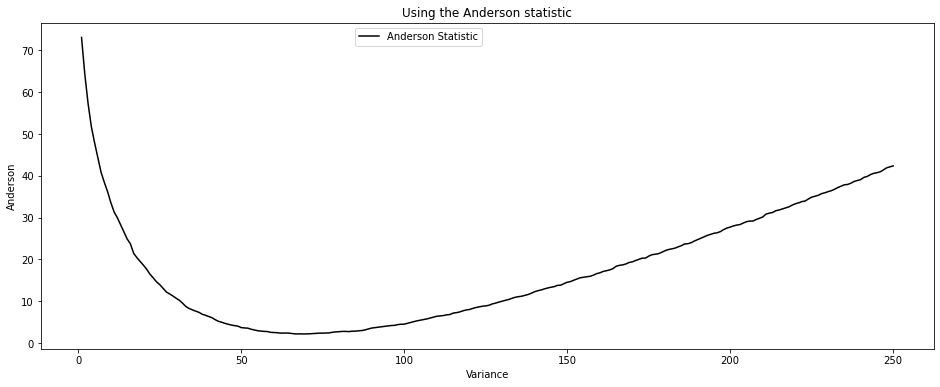

In [61]:
'''
The Anderson-Darling goodness of fit test is a variation of the KS test which gives more weight to the tails
'''
p_values = []

for variance in range(1, 251):
    values = np.array([int(e) for e in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    anderson = anderson_statistic(x=values, dist=poisson, params=[lmbda], fit=False)
    p_values.append({'Variance': variance, 'Anderson':anderson})

df = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Using the Anderson statistic')
line = sns.lineplot(data=df, x='Variance', y='Anderson', label='Anderson Statistic', color='black', sort=False, ax=ax)

line.legend(bbox_to_anchor=(0.5, 1))


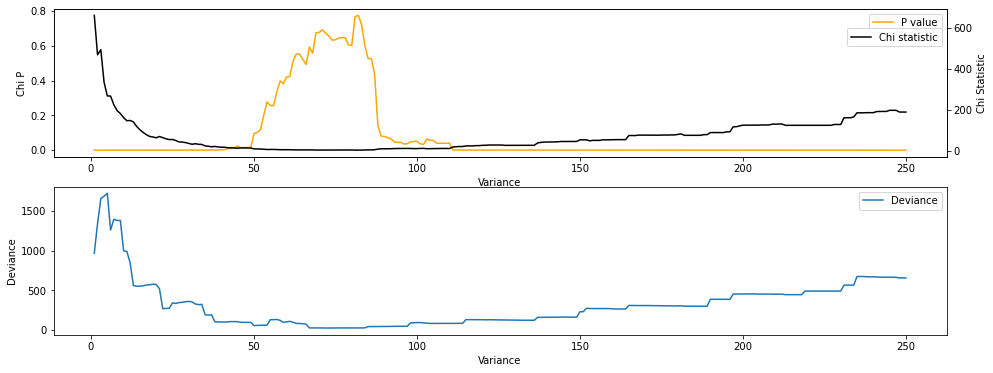

In [62]:
'''
Chi-square test - the only problem with this test is getting the data into the correct format before calculating the test statistic
Added deviance to this, as mentioned in https://data.princeton.edu/wws509/notes/c4.pdf as another measure of goodness of fit
Add to this to show difference between observed and expected
'''
chi_2_contingency = []
p_values = []

for variance in range(1,251):
    new_df = []
    values = np.array([int(e) for e in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    groups = pd.qcut(x=values, q=5, retbins=True, precision=100, duplicates='drop')[1]
    for num, (first, last) in enumerate(zip(groups[:-1], groups[1:]), start=1):
        if num == 1:
            freq = len(np.where(values <= last)[0])
            new_df.append({'Values': f'<{last}', 'Observed Frequency': freq, 'Expected Frequency': poisson.cdf(k=last, mu=lmbda) * len(values)})
        elif num == len(groups) - 1:
            freq = len(np.where(values >= first)[0])
            new_df.append({'Values': f'>{first}', 'Observed Frequency': freq, 'Expected Frequency': (1 - poisson.cdf(k=first, mu=lmbda)) * len(values)})
        else:
            freq = len(np.where((values > first) & (values <= last))[0])
            new_df.append({'Values': f'{first}-{last}', 'Observed Frequency': freq, 'Expected Frequency': (poisson.cdf(k=last, mu=lmbda) - poisson.cdf(k=first, mu=lmbda)) * len(values)})

    df1 = pd.DataFrame(new_df)
    chi_p = chisquare(f_obs=df1['Observed Frequency'], f_exp=df1['Expected Frequency'], axis=None)[1]
    chi_stat = chisquare(f_obs=df1['Observed Frequency'], f_exp=df1['Expected Frequency'], axis=None)[0]
    dev = [e*np.log(e/f) - (e - f) for e in df1['Observed Frequency'] for f in df1['Expected Frequency'] if f != 0]
    deviance = 2*sum(dev)
    p_values.append({'Variance':variance, 'Chi P': chi_p, 'Chi Statistic': chi_stat, 'Deviance': deviance})

df2 = pd.DataFrame(p_values).fillna(value=0)

fig, ax = plt.subplots(2,1,figsize=(16,6))

lineA = sns.lineplot(data=df2, x='Variance', y='Chi P', color='orange', label='P value', sort=False, ax=ax[0])
lineA.legend(bbox_to_anchor=(1,1))
lineB = sns.lineplot(data=df2, x='Variance', y='Chi Statistic', color='black', label = 'Chi statistic', sort=False, ax=ax[0].twinx())
lineB.legend(bbox_to_anchor=(1,0.90))
lineC = sns.lineplot(data=df2, x='Variance', y='Deviance',label='Deviance', sort=False, ax=ax[1])
lineC.legend(bbox_to_anchor=(1,1))




In [ ]:
'''
Try this using bayesian inference for estimation of lambda
Also consider confidence interval for MLE of lambda, relates to chi squared, check notes
'''


In [63]:
'''
What does the df produced by the chi square look like
'''
df1

,Values,Observed Frequency,Expected Frequency
0,<49.0,52,14.977709
1,49.0-59.0,54,87.486864
2,59.0-66.0,50,83.675845
3,66.0-73.20000000000002,44,47.545940
4,>73.20000000000002,50,16.313642


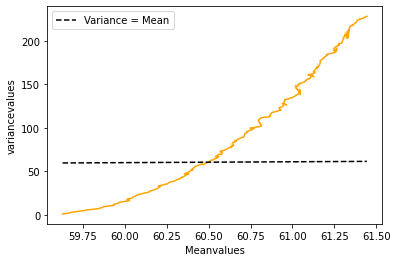

In [64]:
'''
Modelling overdispersion
'''
vals = []
for variance in range(1,251):
     values = np.array([int(e) for e in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
     mean = values.mean()
     var = values.var()
     vals.append({'Variance':variance, 'Meanvalues':mean, 'variancevalues':var})

df = pd.DataFrame(vals)
fig, ax = plt.subplots()

line1 = sns.lineplot(data=df, x='Meanvalues', y='variancevalues', color='orange', sort=False, ax=ax)
line2 = sns.lineplot(data=df, x='Meanvalues', y='Meanvalues', color='black', linestyle='--', label='Variance = Mean', ax=ax)

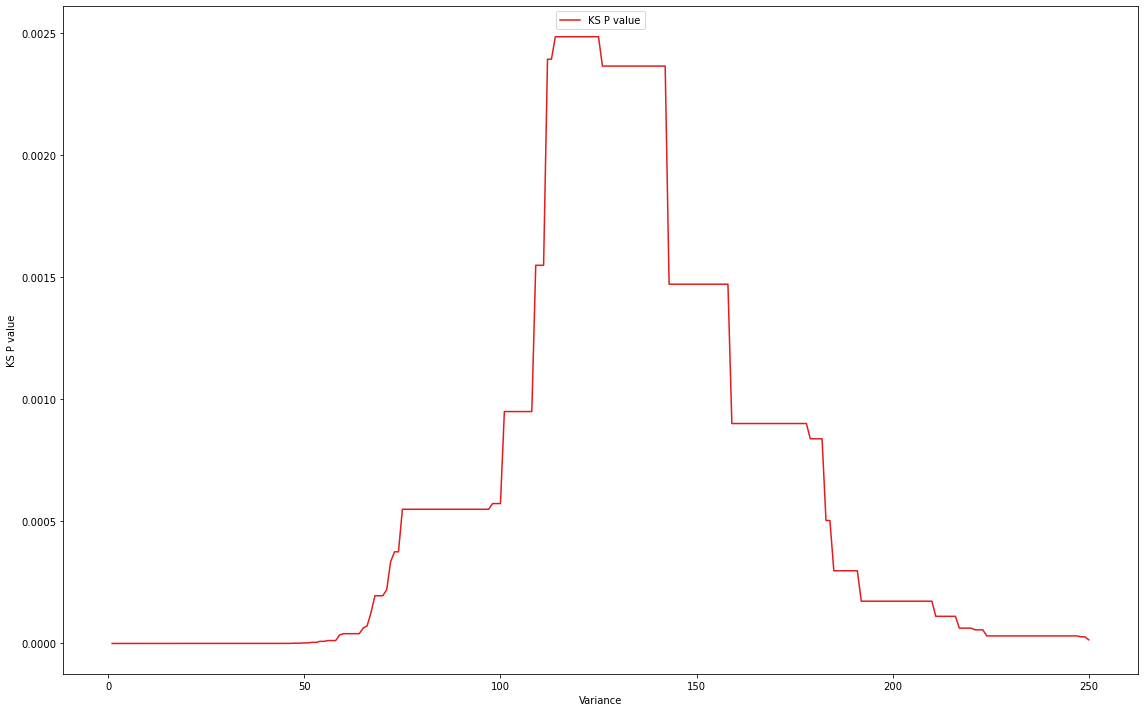

In [80]:
'''
Generate the data in the exact same way but use a neg binom to account for overdispersion
https://data.princeton.edu/wws509/notes/c4a.pdf good 
mean so high close to normal distribution, try using lmbda as an approximation and modelling mean and variance separately? LOOK INTO THIS
The reason we get the dip ~2x greater than the mean could be because of overdispersion
https://stats.stackexchange.com/questions/201903/how-to-deal-with-overdispersion-in-poisson-regression-quasi-likelihood-negativ

alpha = beta = 1/var
'''
p_values = []
for variance in range(1, 251):
    values = np.array([int(e) for e in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    var = values.var()
    args = (58, 0.49)   #n,p
    ks_p_value = kstest(rvs=values, cdf='nbinom', N=len(values), args=args, alternative='two-sided')[1]
    p_values.append({'Variance':variance, 
                    'KS Pvalue': ks_p_value,
                    'Value of n': n})


df = pd.DataFrame(p_values)
fig, ax = plt.subplots(figsize=(16,10), tight_layout=True)

line = sns.lineplot(data=df, x='Variance', y='KS Pvalue', label='KS P value', hue='Value of n', sort=False, legend=False, palette='Set1', ax=ax)
line.set_ylabel('KS P value')
line.legend(loc=9, bbox_to_anchor=(0.5, 1))

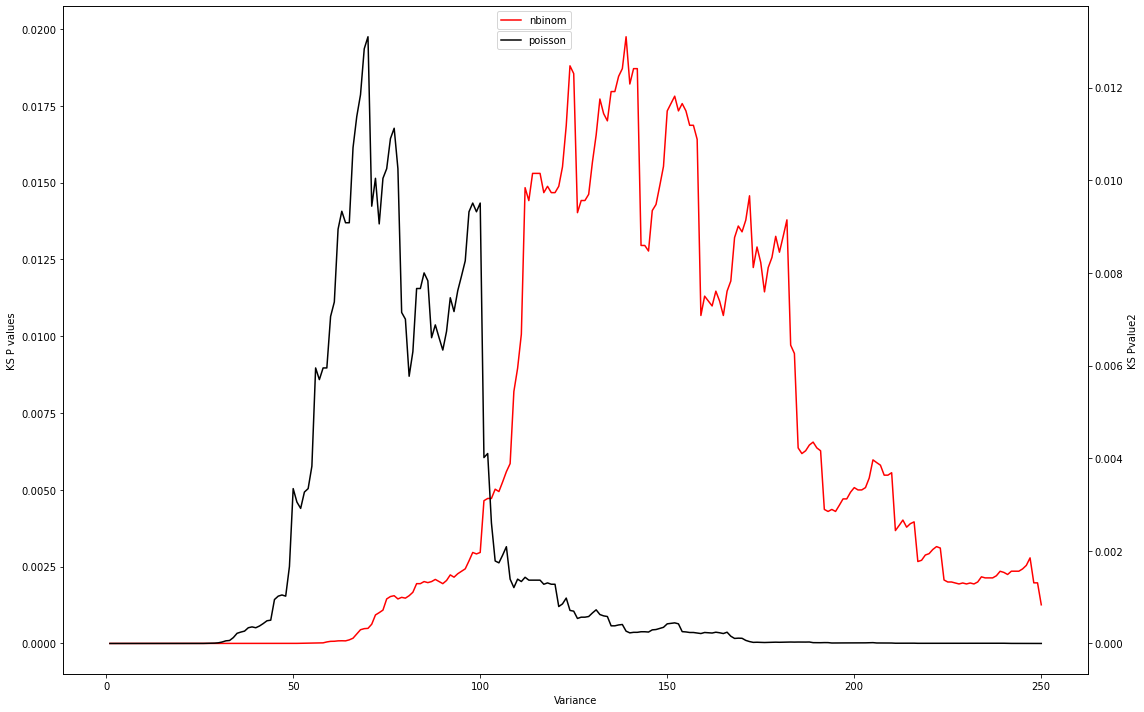

In [81]:
'''
Combine the poisson and the NB?

Note poisson rises until 1.5x mean, so try pr/(1-p) ~ 300
say r is fixed at lmbda tf
p = 300lmbda/lmbda doesnt work
Complementary modelling
'''
p_values = []
for variance in range(1, 251):
    values = np.array([int(e) for e in norm.rvs(loc=60, scale=math.sqrt(variance), size=250, random_state=113)])
    lmbda = values.mean()
    n=lmbda
    args = (n, lmbda/(n+lmbda))   #n,p
    ks_p_value1 = kstest(rvs=values, cdf='nbinom', N=len(values), args=args, alternative='two-sided')[1]
    ks_p_value2 = kstest(rvs=values, cdf='poisson', N=len(values), args=[lmbda], alternative='two-sided')[1]
    p_values.append({'Variance':variance, 
                    'KS Pvalue1': ks_p_value1,
                    'KS Pvalue2': ks_p_value2})


df = pd.DataFrame(p_values)
fig, ax = plt.subplots(figsize=(16,10), tight_layout=True)

ax.set_ylabel('KS P values')
line1 = sns.lineplot(data=df, x='Variance', y='KS Pvalue1', label='nbinom', sort=False, legend=False,color='red', ax=ax)
line1.legend(bbox_to_anchor=(0.5, 1))
line2  = sns.lineplot(data=df, x='Variance', y='KS Pvalue2', label='poisson', sort=False, legend=False,color='black', ax=ax.twinx())
line2.legend(bbox_to_anchor=(0.5, 0.97))

[]

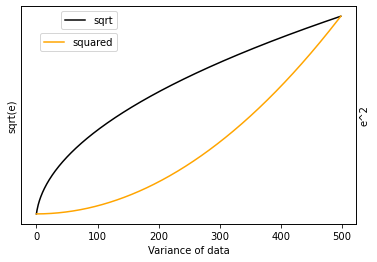

In [82]:
'''
A reason not to use math.sqrt(variance)?
Not biased
'''
lst = [math.sqrt(e) for e in range(1, 500)]
lst2 = [e**2 for e in range(1, 500)]

fig, ax = plt.subplots(sharex=True)
l1 = sns.lineplot(x=np.arange(len(lst)), y=lst,label='sqrt', color='black', ax=ax)
l1.legend(bbox_to_anchor=(0.3, 1))
l1.set_ylabel('sqrt(e)')
l1.set_yticks([])
l1.set_xlabel('Variance of data')
l2 = sns.lineplot(x=np.arange(len(lst2)), y=lst2,label='squared',color='orange', sort=False,ax=ax.twinx())
l2.legend(bbox_to_anchor=(0.3, 0.9))
l2.set_ylabel('e^2')
l2.set_yticks([])